## Advanced Housing Prices Regression

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# import packages

In [0]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from scipy.stats import skew

from scipy.special import boxcox1p

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_log_error

from sklearn.model_selection import KFold

import lightgbm as lgb

import seaborn as sns

# Load the data file

In [0]:
with open('/content/gdrive/My Drive/COMP5121_DataMining/COMP5121 Data Mining Group Project/program/input/train.csv', 'r') as data:
  training_data = pd.read_csv(data) # pd.read_csv('../input/train.csv')

with open('/content/gdrive/My Drive/COMP5121_DataMining/COMP5121 Data Mining Group Project/program/input/test.csv', 'r') as data:
  test_data = pd.read_csv(data) # pd.read_csv('../input/train.csv')

In [0]:
#for local only
#training_data = pd.read_csv('../input/train.csv')

#test_data = pd.read_csv('../input/test.csv')

In [31]:
training_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


# Transform categorical data's type from integer to string

In [0]:
# Transform MSSubClass to non-numeric data
training_data = training_data.replace({'MSSubClass': {20: 'SubClass_20', 
                                            30: 'SubClass_30', 
                                            40: 'SubClass_40', 
                                            45: 'SubClass_45',
                                            50: 'SubClass_50', 
                                            60: 'SubClass_60',
                                            70: 'SubClass_70',
                                            75: 'SubClass_75',
                                            80: 'SubClass_80',
                                            85: 'SubClass_85',
                                            90: 'SubClass_90',
                                           120: 'SubClass_120',
                                           150: 'SubClass_150',
                                           160: 'SubClass_160',
                                           180: 'SubClass_180',
                                           190: 'SubClass_190'}})

test_data = test_data.replace({'MSSubClass': {20: 'SubClass_20', 
                                            30: 'SubClass_30', 
                                            40: 'SubClass_40', 
                                            45: 'SubClass_45',
                                            50: 'SubClass_50', 
                                            60: 'SubClass_60',
                                            70: 'SubClass_70',
                                            75: 'SubClass_75',
                                            80: 'SubClass_80',
                                            85: 'SubClass_85',
                                            90: 'SubClass_90',
                                           120: 'SubClass_120',
                                           150: 'SubClass_150',
                                           160: 'SubClass_160',
                                           180: 'SubClass_180',
                                           190: 'SubClass_190'}})

# Remove outlier 

(0, 800000)

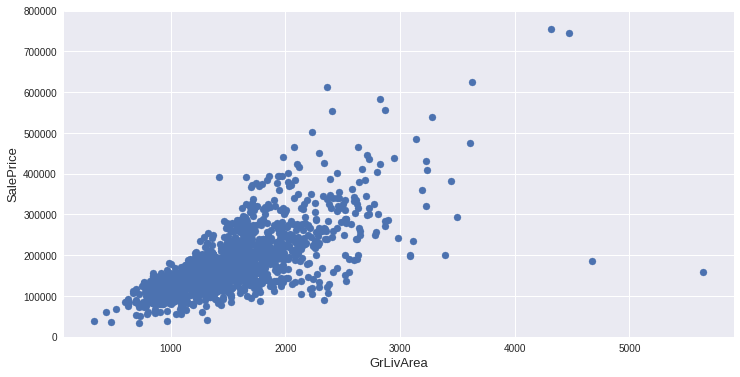

In [33]:
plt.figure(figsize=(12,6))
plt.scatter(x=training_data.GrLivArea, y=training_data.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [0]:
training_data = training_data[~((training_data['GrLivArea'] > 4000) & (training_data['SalePrice'] < 300000))] #filter out potentially uniquely huge houses that don't fit the general trend as told by the documentation

# Combine training & testing data for preprocessing

In [0]:
combined_data = pd.concat((training_data.loc[:,'MSSubClass':'SaleCondition'],
                           test_data.loc[:,'MSSubClass':'SaleCondition']), ignore_index=True)#load the CSV's into an object

# Select Feature with Correlation Analysis

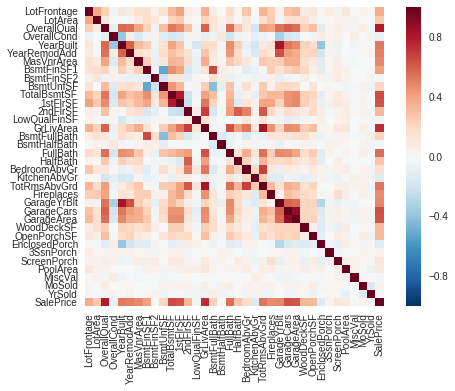

In [36]:
# Generate heatmap for training data
corr = training_data.select_dtypes(include = ['float64', 'int64']).iloc[:,1:].corr()
sns.set(font_scale=1)  
sns.heatmap(corr, vmax=1, square=True)

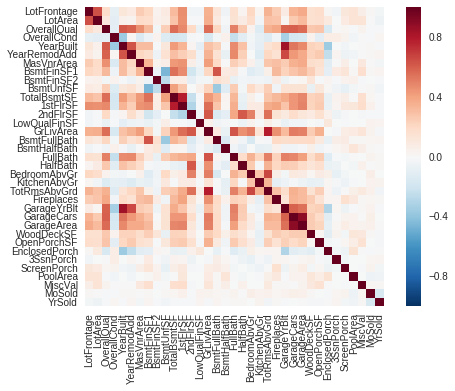

In [37]:
# Generate heatmap for test data
corr = test_data.select_dtypes(include = ['float64', 'int64']).iloc[:,1:].corr()
sns.set(font_scale=1)  
sns.heatmap(corr, vmax=1, square=True)

Correlations for training set and test set are not entirely the same.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


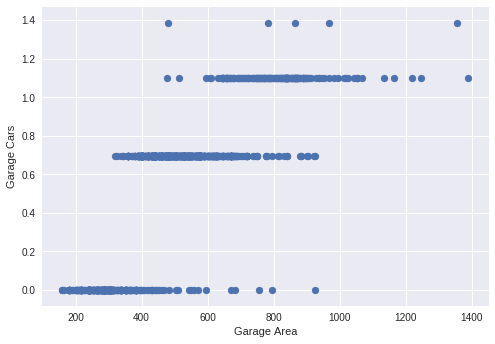

In [38]:
plt.scatter(x=training_data['GarageArea'], y=np.log(training_data['GarageCars']))
plt.ylabel('Garage Cars')
plt.xlabel('Garage Area')
plt.show()

Text(0,0.5,'SalePrice')

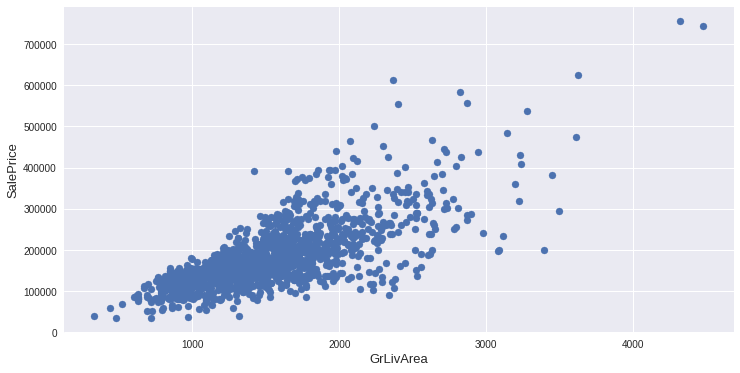

In [39]:
plt.figure(figsize=(12,6))
plt.scatter(x=training_data.GrLivArea, y=training_data.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


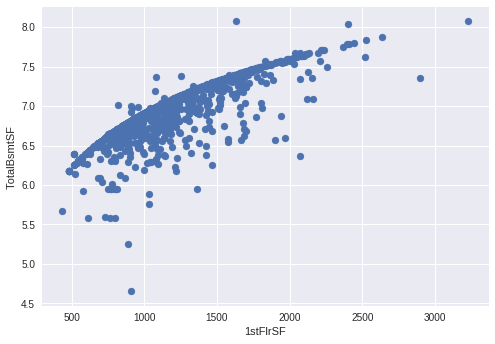

In [40]:
plt.scatter(x=training_data['1stFlrSF'], y=np.log(training_data['TotalBsmtSF']))
plt.ylabel('TotalBsmtSF')
plt.xlabel('1stFlrSF')
plt.show()

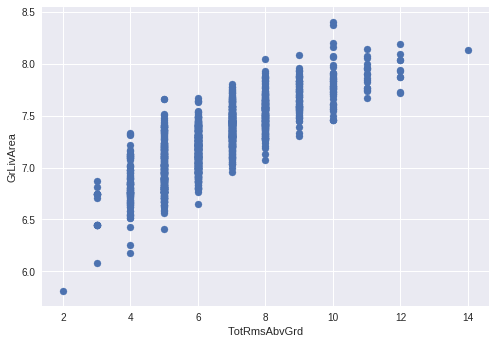

In [41]:
plt.scatter(x=training_data['TotRmsAbvGrd'], y=np.log(training_data['GrLivArea']))
plt.ylabel('GrLivArea')
plt.xlabel('TotRmsAbvGrd')
plt.show()



```
# This is formatted as code
```
Drop unimportant columns (Too Correlated with other features)

In [0]:
# Drops unimportant columns, because 
# TotalBsmtSF and 1stFlrSF have similarly high correlation
# GarageArea and GarageCars have high correlation
# TotRmsAbvGrd & GrLivArea may have high correlation

combined_data.drop(['GarageArea', 'TotRmsAbvGrd'], axis=1, inplace=True)  #drops unimportant columns

# Perform Transfromation (1)

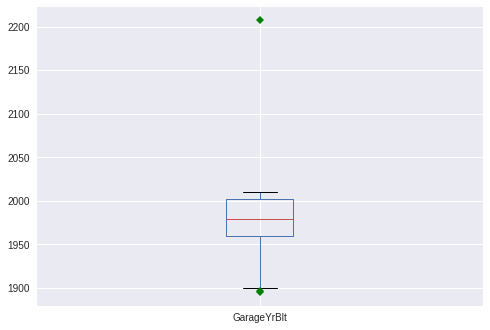

In [43]:
#clipping
combined_data['GarageYrBlt'].plot.box(flierprops=dict(markerfacecolor='g', marker='D'))

In [44]:
combined_data['GarageYrBlt'].nlargest(5)

2590    2207.0
378     2010.0
818     2010.0
986     2010.0
1500    2010.0
Name: GarageYrBlt, dtype: float64

In [0]:
def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(min(max(x, clip_to_min), clip_to_max)))

In [0]:
combined_data['GarageYrBlt'] = clip(combined_data['GarageYrBlt'], 0, 2010)

# Derive new features

In [47]:
#Baron feature added
combined_data['NoOfYrSold']=(combined_data['YrSold'].max()-combined_data['YrSold'])
#combined_data['NoOfYrBuilt']=(combined_data['YearBuilt'].max()-combined_data['YearBuilt'])
#features['NoOfYearRemodAdd']=(2010-features['YearRemodAdd'])
combined_data['NoOfGarageYrBlt']=(combined_data['GarageYrBlt'].max()-combined_data['GarageYrBlt'])
combined_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,NoOfYrSold,NoOfGarageYrBlt
0,SubClass_60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,2,7.0
1,SubClass_20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,3,34.0
2,SubClass_60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,2,9.0
3,SubClass_70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,4,12.0
4,SubClass_60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,2,10.0


In [0]:
#Baron
combined_data['Total_sqr_footage'] = (combined_data['BsmtFinSF1'] + combined_data['BsmtFinSF2'] +
                                      combined_data['1stFlrSF'] + combined_data['2ndFlrSF'])

combined_data['Total_Bathrooms'] = (combined_data['FullBath'] + (0.5*combined_data['HalfBath']) + 
                                    combined_data['BsmtFullBath'] + (0.5*combined_data['BsmtHalfBath']))

combined_data['Total_porch_sf'] = (combined_data['OpenPorchSF'] + combined_data['3SsnPorch'] +
                                   combined_data['EnclosedPorch'] + combined_data['ScreenPorch'] +
                                   combined_data['WoodDeckSF'])


In [0]:
#Baron
#simplified features=bad
#combined_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
#combined_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
#combined_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
#combined_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
#combined_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Fill in missing value (1)

In [0]:
#Baron
# Fill N/A values
combined_data['Functional'] = combined_data['Functional'].fillna('Typ')
combined_data['Electrical'] = combined_data['Electrical'].fillna("SBrkr")
combined_data['KitchenQual'] = combined_data['KitchenQual'].fillna("TA")

combined_data['Exterior1st'] = combined_data['Exterior1st'].fillna(combined_data['Exterior1st'].mode()[0])
combined_data['Exterior2nd'] = combined_data['Exterior2nd'].fillna(combined_data['Exterior2nd'].mode()[0])

combined_data['SaleType'] = combined_data['SaleType'].fillna(combined_data['SaleType'].mode()[0])

# Perform Transfomation (2)

In [0]:
#log transfomration
training_data["SalePrice"] = np.log1p(training_data["SalePrice"]) #logarithmically convert the sale price of the test data. This creates an easier to predict value that leaves less room for prediction errors (for the training data)


In [0]:
#box cox transformation for high skewed data
num_carcts = combined_data.dtypes[combined_data.dtypes != "object"].index #find the non object data in the csv's

skewed_carcts = combined_data[num_carcts].apply(lambda x: skew(x.dropna())) #identify data skew in the training data

skewed_carcts = skewed_carcts[abs(skewed_carcts) > 0.65] 

skewed_carcts = skewed_carcts.index

In [53]:
skewed_carcts

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'Fireplaces',
       'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'NoOfGarageYrBlt',
       'Total_sqr_footage', 'Total_porch_sf'],
      dtype='object')

In [0]:
combined_data[skewed_carcts] = boxcox1p(combined_data[skewed_carcts], 0.15)

# One Hot Encoding

In [0]:
combined_data = pd.get_dummies(combined_data)

# Fill Missing value (2)

In [81]:
combined_data = combined_data.fillna(combined_data.mean())
combined_data.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.831328,19.212182,7,5,2003,2003,8.059126,11.170327,0.0,7.483296,...,0,0,0,1,0,0,0,0,1,0
1,6.221214,19.712205,6,8,1976,1976,0.000000,12.062832,0.0,8.897844,...,0,0,0,1,0,0,0,0,1,0
2,5.914940,20.347241,7,5,2001,2002,7.646538,10.200343,0.0,9.917060,...,0,0,0,1,0,0,0,0,1,0
3,5.684507,19.691553,7,5,1915,1970,0.000000,8.274266,0.0,10.468500,...,0,0,0,1,1,0,0,0,0,0
4,6.314735,21.325160,8,5,2000,2000,9.391827,10.971129,0.0,10.221051,...,0,0,0,1,0,0,0,0,1,0


# Prepare trainging_feauture, training_label, testing_feauture

In [0]:
X_training_data = combined_data[:training_data.shape[0]]

X_test_data = combined_data[training_data.shape[0]:]

y = training_data.SalePrice

# Built model

In [83]:
'''params = {
        'alpha':np.arange(2e-5, 1, 2e-5),
        }

lasso_search = GridSearchCV(Lasso(), 
                                   params, 
                                   cv = 5, 
                                   scoring = 'neg_mean_squared_log_error',  
                                   n_jobs = -1)

lasso_search.fit(X_training_data, y)
lasso_search.best_estimator_'''

"params = {\n        'alpha':np.arange(2e-5, 1, 2e-5),\n        }\n\nlasso_search = GridSearchCV(Lasso(), \n                                   params, \n                                   cv = 5, \n                                   scoring = 'neg_mean_squared_log_error',  \n                                   n_jobs = -1)\n\nlasso_search.fit(X_training_data, y)\nlasso_search.best_estimator_"

In [0]:
#Lasso regression
lasso_model = Lasso(alpha = 0.00048)
lasso_score = cross_val_score(lasso_model, X_training_data, y, scoring='neg_mean_squared_log_error', cv=5).mean()

In [85]:
lasso_model.fit(X_training_data, y)

Lasso(alpha=0.00048, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
lasso_preds = np.expm1(lasso_model.predict(X_test_data))

In [87]:
'''params = {
        'alpha':np.arange(4.4, 5, 2e-5),
        }
ridge_search = GridSearchCV(Ridge(), 
                                   params, 
                                   cv = 5, 
                                   scoring = 'neg_mean_squared_log_error',  
                                   n_jobs = -1)
ridge_search.fit(X_training_data, y)
ridge_search.best_estimator_'''

"params = {\n        'alpha':np.arange(4.4, 5, 2e-5),\n        }\nridge_search = GridSearchCV(Ridge(), \n                                   params, \n                                   cv = 5, \n                                   scoring = 'neg_mean_squared_log_error',  \n                                   n_jobs = -1)\nridge_search.fit(X_training_data, y)\nridge_search.best_estimator_"

In [0]:
#Ridge regression
ridge_model = Ridge(alpha = 5)
ridge_score = cross_val_score(ridge_model, X_training_data, y, scoring='neg_mean_squared_log_error', cv=5).mean()

In [89]:
ridge_model.fit(X_training_data, y)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
ridge_preds = np.expm1(ridge_model.predict(X_test_data))

In [91]:
'''params = {
        'l1_ratio':np.arange(0.1, 2, 0.1),
        'alpha':np.arange(2e-2, 1, 2e-2),
        }
elastic_search = GridSearchCV(ElasticNet(), 
                                   params, 
                                   cv = 5, 
                                   scoring = 'neg_mean_squared_log_error',  
                                   n_jobs = -1)

elastic_search.fit(X_training_data, y)
elastic_search.best_estimator_'''

"params = {\n        'l1_ratio':np.arange(0.1, 2, 0.1),\n        'alpha':np.arange(2e-2, 1, 2e-2),\n        }\nelastic_search = GridSearchCV(ElasticNet(), \n                                   params, \n                                   cv = 5, \n                                   scoring = 'neg_mean_squared_log_error',  \n                                   n_jobs = -1)\n\nelastic_search.fit(X_training_data, y)\nelastic_search.best_estimator_"

In [0]:
#Elastic net regression
elastic_model = ElasticNet(l1_ratio = 0.1,
                             alpha = 0.02
                            )
elastic_score = cross_val_score(elastic_model, X_training_data, y, scoring='neg_mean_squared_log_error', cv=5).mean()

In [93]:
elastic_model.fit(X_training_data, y)

ElasticNet(alpha=0.02, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
elastic_preds = np.expm1(elastic_model.predict(X_test_data))

In [0]:
# lightGBM gradient boosting
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', 
                              learning_rate = 0.018,
                              n_estimators=4000,
                              num_leaves=160,
                              max_depth=6,
                              reg_alpha=0.1,
                              reg_lambda=0.5
                             )
lgb_score = cross_val_score(lgb_model, X_training_data, y, scoring='neg_mean_squared_log_error', cv=5).mean()

In [96]:
lgb_model.fit(X_training_data, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.018, max_depth=6,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=4000, n_jobs=-1, num_leaves=160, objective=None,
       random_state=None, reg_alpha=0.1, reg_lambda=0.5, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
lgb_preds = np.expm1(lgb_model.predict(X_test_data))

In [0]:
#weight averaging of all 4 model
wavg_preds = ((1/lasso_score)*lasso_preds+(1/ridge_score)*ridge_preds+(1/elastic_score)*elastic_preds+(1/lgb_score)*lgb_preds)
wavg_preds = wavg_preds/((1/lasso_score)+(1/ridge_score)+(1/elastic_score)+(1/lgb_score))

In [0]:
kf = KFold(n_splits=5)
actual = np.expm1(y).values
wavg_score = []
for train_index, test_index in kf.split(actual):
  wavg_score.append(mean_squared_log_error(actual[test_index], wavg_preds[test_index]))
wavg_score = -sum(wavg_score)/len(wavg_score)

In [100]:
print('lasso_score = ' +str(lasso_score))
print('ridge_score = ' +str(ridge_score))
print('elastic_score = ' +str(elastic_score))
print('lgb_score = ' +str(lgb_score))
print('wavg_score = ' +str(wavg_score))

lasso_score = -7.363734184723167e-05
ridge_score = -7.748316928073523e-05
elastic_score = -8.577406806784157e-05
lgb_score = -9.889689088708965e-05
wavg_score = -0.3098858815504602


# Deliver result

In [0]:
preds = lasso_preds

In [0]:
#for local only
#solution.to_csv("../output/submission.csv", index = False)

In [0]:
solution = pd.DataFrame({"id":test_data.Id, "SalePrice":preds})

with open('/content/gdrive/My Drive/COMP5121_DataMining/COMP5121 Data Mining Group Project/program/output/submission.csv', 'w') as data:
    output=solution.to_csv(data)

# BACKUP CODE

In [105]:
!pip install catboost

    100% |████████████████████████████████| 55.5MB 493kB/s 


In [106]:


from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(iterations=2000, learning_rate=0.025, depth=6)

# Fit model
cat_model.fit(X_training_data,y)
# Get predictions
cat_preds = np.expm1(cat_model.predict(X_test_data))

0:	learn: 11.7358347	total: 91.7ms	remaining: 3m 3s
1:	learn: 11.4493394	total: 129ms	remaining: 2m 8s
2:	learn: 11.1691721	total: 160ms	remaining: 1m 46s
3:	learn: 10.8993375	total: 194ms	remaining: 1m 37s
4:	learn: 10.6332553	total: 227ms	remaining: 1m 30s
5:	learn: 10.3707397	total: 257ms	remaining: 1m 25s
6:	learn: 10.1150508	total: 287ms	remaining: 1m 21s
7:	learn: 9.8662808	total: 323ms	remaining: 1m 20s
8:	learn: 9.6268065	total: 356ms	remaining: 1m 18s
9:	learn: 9.3899093	total: 389ms	remaining: 1m 17s
10:	learn: 9.1608960	total: 420ms	remaining: 1m 16s
11:	learn: 8.9359467	total: 452ms	remaining: 1m 14s
12:	learn: 8.7169015	total: 485ms	remaining: 1m 14s
13:	learn: 8.5065540	total: 516ms	remaining: 1m 13s
14:	learn: 8.3001336	total: 557ms	remaining: 1m 13s
15:	learn: 8.0970401	total: 589ms	remaining: 1m 13s
16:	learn: 7.8988713	total: 622ms	remaining: 1m 12s
17:	learn: 7.7056446	total: 655ms	remaining: 1m 12s
18:	learn: 7.5174177	total: 688ms	remaining: 1m 11s
19:	learn: 7.334

In [107]:
#Top 2% Lasso CV 0.11609
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LassoCV


alphas = [0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 
          0.0009, 0.01]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]


lasso_model2 = make_pipeline(RobustScaler(),
                             LassoCV(max_iter=1e7,
                                    alphas = alphas2,
                                    random_state = 42)).fit(X_training_data, y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
